# Simulating growth
The true strength of this package is in its ability to simulate cardiac growth. 

## Background
### Mechanics-based growth models
We included several mechanics-based growth relationships based on reference [1-4]. The choice of growth model is up to the user and can be specified in the input file in `growth.type`. We use the kinematic growth model framework from Rodriguez et al. [5]. In brief, the way that all these models work is that they compare the current state of mechanics (typically elastic stretch) in each cardiac wall patch to that of a previous state. The growth model then calculates the amount of growth based on the difference between these states. The growth tensor *F_g* for each cardiac wall patch can be calculated using the following growth relationships:
1. `transverse_jones`: Transversely isotropic growth driven by changes in fiber (fiber/cross-fiber growth) and radial (radial growth) stretch based on Jones & Oomen [1].
2. `transverse_witzenburg`: Transversely isotropic growth driven by changes in fiber (fiber/cross-fiber growth) and radial (radial growth) stretch based on Witzenburg & Holmes [2].
3. `isotropic_oomen`: Isotropic growth driven by changes in fiber stretch based on Oomen et al. [3].
4. `isotropic_jones`: Isotropic growth driven by changes in fiber stretch based on Jones & Oomen [1].
5. `transverse_hybrid`: Combination of the transverse_jones and transverse_witzenburg growth models.

If you desire a different growth model, you can conveniently add your own growth model(s) in the `growth.py` file.

### Drivers of growth
The changes in mechanics that drive growth can be induced by a variety of pathologies or clinical interventions. The boundary conditions needed to simulate these can be specified in the `growth` section of the input file. The following drivers are implemented:
1. Systemic arterial resistance (`growth.ras`): to simulate changes in afterload e.g. due to aortic stenosis.
2. Mitral valve regurgitation (`growth.rmvb`): to simulate changes in preload due to mitral valve regurgitation.
3. Abnormal heart rate (`growth.hr`): to simulate changes in heart rate.
4. Blood volume (`growth.sbv`): to simulate changes in blood volume and/or vasoconstriction.
5. Myocardial ischemia (`growth.ischemic`): to simulate changes in contractility due to acute ischemia (no stiffening during chronic ischemia is implemented as of yet).
6. Dyssynchrony (`growth.t_act`): to simulate changes in activation timing such as in left bundle branch block and cardiac resynchronization therapy.
 
All these parameters will override the values specified in the other parameter sections (`heart`, `circulation`, `resistances`). The first 4 parameters need to be specified for each time point in the growth simulation, whereas changes in ischemia and dyssynchrony can be triggered at specific time points and need to be defined for each cardiac wall patch.

In [1]:
# Jupyter magic
%load_ext autoreload
%autoreload 2

## Example: mitral valve regurgitation
We will here simulate transversely isotropic growth in a canine model with mitral valve regurgitation based on Jones & Oomen [1]. Just as in the single beat simulations, we need to specify the input file which contains the baseline model characteristics as well the growth boundary conditions. We use the `growth.rmvb` parameter to simulate mitral valve regurgitation and the growth model `transverse_jones` to simulate transversely isotropic growth. The model parameters are set to reflect a typical mitral regurgitation case in canines, see [1] for a more rigorous parameter calibration.

Just like in the single beat simulations, we first need to (1) initialize the model, (2) simulate growth, and (3) visualize the results. Start with model intitialization and print the baseline and acute mitral valve regurgitation parameters:

In [3]:
from monarch import Hatch
import pathlib

# Initialize model
input_dir = pathlib.Path.cwd() / "input_files"
input_canine = input_dir / "canine_vo"
beats = Hatch(input_canine)

print("Growth type: " + beats.growth.type)
print("Baseline R_mvb: " + str(beats.growth.rmvb[0]))
print("Acute R_mvb: " + str(beats.growth.rmvb[1]))

Growth type: transverse_jones
Baseline R_mvb: 10000000000.0
Acute R_mvb: 0.3


A lower resistance means there is more regurgitation, with the intitial value set sufficiently high to ensure no regurgitation. We can now simulate growth , note that just like in the single beat simulations, the first simulation you run may take a while as the model is compiled. Subsequent simulations will be faster, rerun the cell to see this for yourself.

In [4]:
# Simulate growth
beats.let_it_grow()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

All model readouts are included in a Pandas format table `beat.growth.outputs`, similar to the single beat `beat.outputs` table but now every row includes a growth time point, with the index indicating which time point (in days).

In [ ]:
beats.growth.outputs

For easier analysis, any of the growth outputs can be plotted over time using the `plot_growth` function. The function takes a list of outputs (and optional units for plotting purposes) to plot. Here we plot the left ventricular end-diastolic volume (LVEDV) and end-systolic volume (LVESV):

KeyError: 'LVEDV'

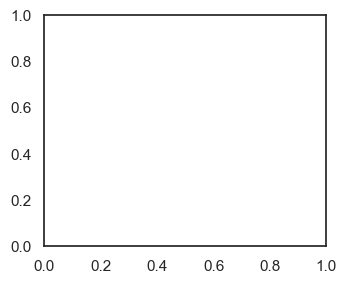

In [6]:
import monarch.metamophoses as meta

meta.plot_growth(beats, ["LVEDV", "LVESV"], units=["mL", "mL"])

One can also plot the pressure-volume loops of a single compartment over time. Here we plot the pressure-volume loop of the left ventricle at all time points (default); and the first, second, and last time point (specified through `index` argument):

In [5]:
meta.pv_loop_growth(beats)
meta.pv_loop_growth(beats, index=(0, 1, -1))

NameError: name 'meta' is not defined

The growth tensor *F_g* can be visualized using the `plot_fg` function. Note how there is only growth in the left free wall (LFW) and septal wall (SW) as mitral regurgitation only effects the left ventricle. As expected from experimental and clinical studies, we observe dilation (increase in fiber (11) and cross-fiber (22) components of the growth tensor) and wall thinning (decrease in the radial (33) component of the growth tensor) in the LFW and SW. Initially, the change in wall volume due to growth (*J_g*) decreases due to faster thinning than dilation, but eventually the wall volume increases due to dilation exceeding wall thinning.

In [ ]:
meta.plot_fg(beats)

### Isotropic growth
Let's now simulate isotropic growth in a canine model with mitral valve regurgitation. We will use the `isotropic_jones` growth model to simulate isotropic growth.

In [7]:
# Initialize model and change growth type
beats = Hatch(input_canine)
beats.growth.type = "isotropic_jones"

# Simulate growth
beats.let_it_grow()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

Use the standard plotting functions to visualize the results, note now how there is a smaller increase in LVEDV and even a decrease in LVESV compared to the transversely isotropic growth model.

KeyError: 'LVEDV'

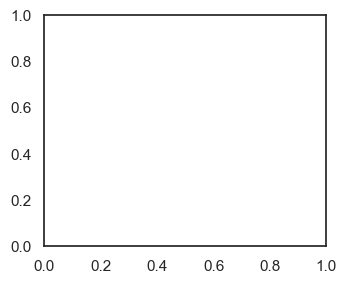

In [8]:
meta.plot_growth(beats, ["LVEDV", "LVESV"], units=["mL", "mL"])
meta.pv_loop_growth(beats)

This is due to the isotropic growth model not allowing for wall thinning:

In [ ]:
meta.plot_fg(beats)

## References
[1] Jones, C. E. & Oomen, P. J. A. Synergistic Biophysics and Machine Learning Modeling to Rapidly Predict Cardiac Growth Probability. bioRxiv 2024.07.17.603959 (2024) doi:10.1101/2024.07.17.603959.
[2] Oomen, P. J. A., Phung, T.-K. N., Weinberg, S. H., Bilchick, K. C. & Holmes, J. W. A rapid electromechanical model to predict reverse remodeling following cardiac resynchronization therapy. Biomech Model Mechan 21, 231–247 (2022).
[3] Witzenburg, C. M. & Holmes, J. W. Predicting the Time Course of Ventricular Dilation and Thickening Using a Rapid Compartmental Model. J Cardiovasc Transl 11, 109–122 (2018).
[4] Göktepe, S., Abilez, O. J., Parker, K. K. & Kuhl, E. A multiscale model for eccentric and concentric cardiac growth through sarcomerogenesis. J Theor Biol 265, 433–442 (2010).
[5] Rodriguez, E. K., Hoger, A. & McCulloch, A. D. Stress-dependent finite growth in soft elastic tissues. J Biomech 27, 455–467 (1994).